Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [18]:
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166 https://drive.google.com/drive/folders/1VHYvhlrjXBVEZXa-BxjHNsn9DcoboaL_?usp=drive_link

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [51]:
# Defining the path for train and test images

root_path = '/content/gdrive/MyDrive/CNN_assignment/Skincancer'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [20]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Creating train and test dataset

In [21]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [22]:
#creating train ds
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [23]:
#creting test ds
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [24]:
#Checking all clases
class_names = train_ds.class_names
print(class_names)

['actinic_keratosis', 'basal_cell_carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented_benign_keratosis', 'seborrheic_keratosis', 'squamous_cell_carcinoma', 'vascular_lesion']


### Visualizing the data

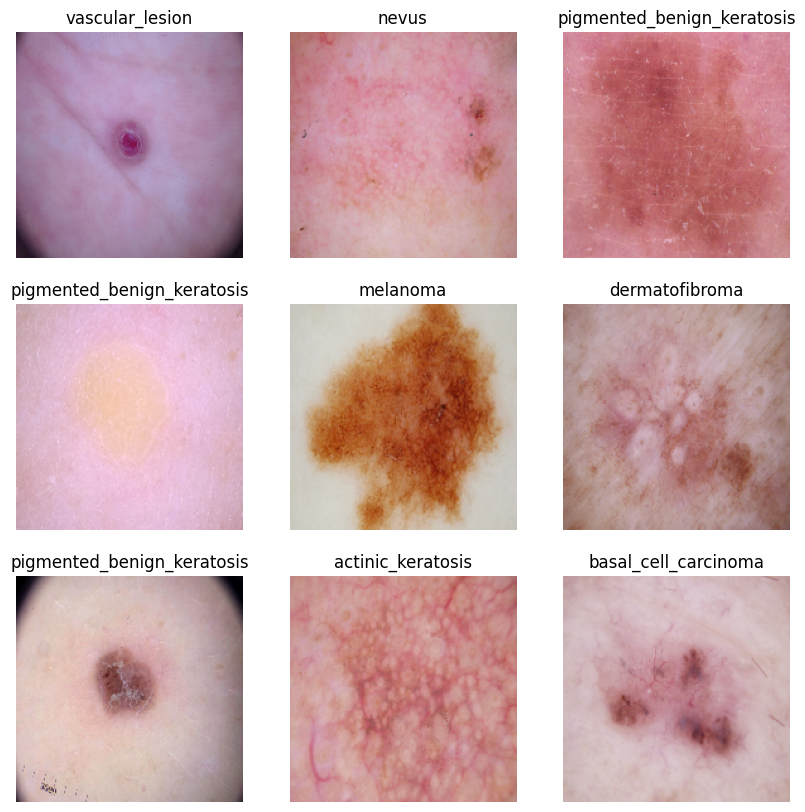

In [25]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [26]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model 1 Building

In [27]:
from tensorflow.keras import layers


In [28]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout, Activation
import tensorflow as tf

# Preprocessing layers
preprocessing_layers = [
    tf.keras.layers.Rescaling(1./255, input_shape=(180, 180, 3))
]

input_shape = (180, 180, 3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()

# Use Rescaling layer correctly (no 'experimental')
model.add(tf.keras.layers.Rescaling(1./255, input_shape=input_shape))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# Summary of the model
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 176, 176, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 88, 88, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 86, 86, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 86, 86, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 41, 41, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      26,214,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,318,689 (100.40 MB)

 Trainable params: 26,318,305 (100.40 MB)

 Non-trainable params: 384 (1.50 KB)

### Compile the model 1
Choose an appropirate optimiser and loss function for model training

In [29]:
### optimiser and loss function

optimizer = 'adam'
loss_fn = "binary_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [30]:
# View the summary of all layers
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 176, 176, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 88, 88, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 86, 86, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 86, 86, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 41, 41, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      26,214,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,318,689 (100.40 MB)

 Trainable params: 26,318,305 (100.40 MB)

 Non-trainable params: 384 (1.50 KB)

### Train the model

In [31]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - accuracy: 0.1748 - loss: -27920.2227 - val_accuracy: 0.1499 - val_loss: -82033.5000
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - accuracy: 0.1741 - loss: -569244.3750 - val_accuracy: 0.1499 - val_loss: -803359.6875
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.1667 - loss: -2292336.7500 - val_accuracy: 0.1499 - val_loss: -2980549.2500
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.1751 - loss: -5943642.5000 - val_accuracy: 0.1499 - val_loss: -6445465.0000
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.1722 - loss: -12469102.0000 - val_accuracy: 0.1499 - val_loss: -12987119.0000
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.1575 - loss: -22168142.0000 - val_accuracy: 0.1499 - val_loss: -31312764.0000
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.1842 - loss: -35513900.0000 - val_accuracy: 0.1499 - val_loss: -39158140.0000
Epoch 8/20
5

### Visualizing training results for model 1

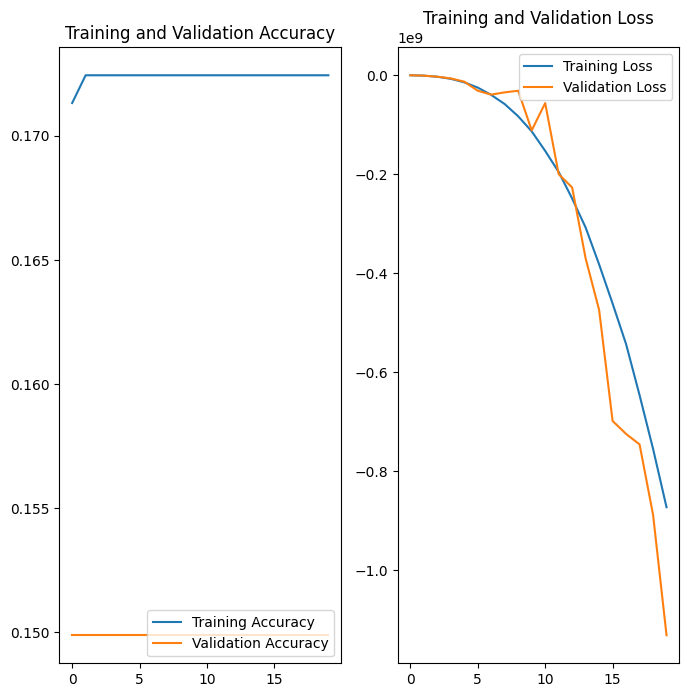

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


# Thus we can clearly that model Overfit and we need to chose right data augumentation strategy

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1735 - loss: -1090879232.0000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1446 - loss: -1119999104.0000
Accuracy:  0.1724330335855484
Validation Accuracy:  0.14988814294338226
Loss:  -1104569088.0
Validation Loss -1130797696.0


#### Model 1 Infrences :
Training Accuracy: Flat, constant at a very low value (~0.17).

Validation Accuracy: Similar to training accuracy, almost no improvement.
Training Loss: Shows an unusual trend, decreasing into large negative values (unexpected behavior).

Validation Loss: Mirrors training loss but also enters large negative values.

### Model 2 Buidling

Applying data augumentation strategy


In [34]:
batch_size = 32
img_height = 180
img_width = 180

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

train_batches = datagen.flow_from_directory(data_dir_train,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(data_dir_test,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)

Found 1081 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


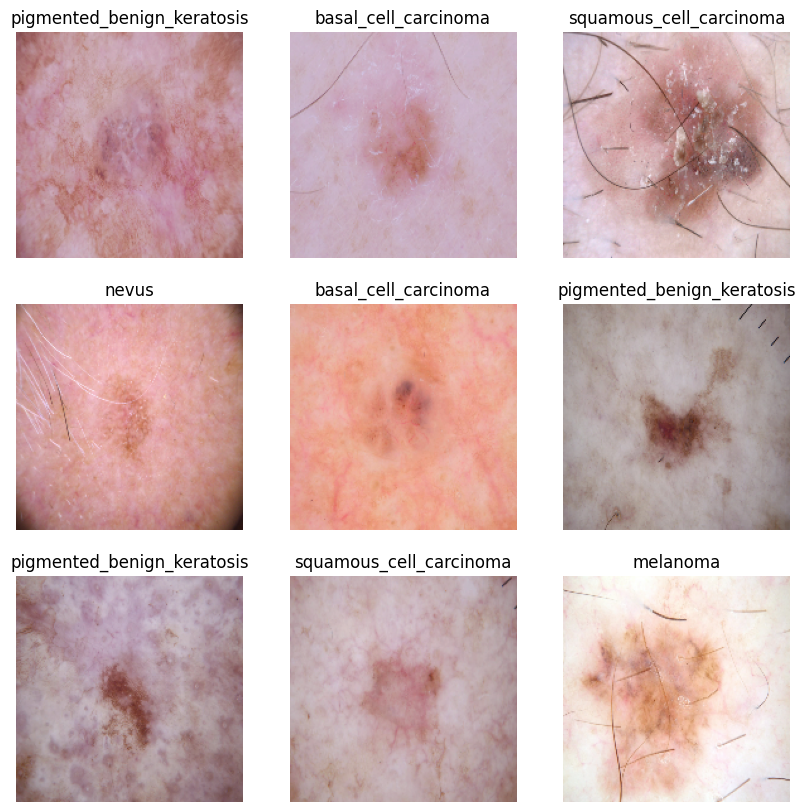

In [36]:
# visualize how  augmentation strategy works
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [37]:

model = Sequential()

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 90, 90, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 43, 43, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 56448)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      28,901,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,045,929 (110.80 MB)

 Trainable params: 29,045,929 (110.80 MB)

 Non-trainable params: 0 (0.00 B)

### Compiling the model 2

In [38]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


### Training the model 2

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up the data generator
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

# Print the paths to verify the directories
print("Training data directory:", data_dir_train)
print("Testing data directory:", data_dir_test)

# Set up the training and validation batches
train_batches = datagen.flow_from_directory(
    data_dir_train,
    target_size=(180, 180),
    batch_size=64
)

valid_batches = datagen.flow_from_directory(
    data_dir_test,
    target_size=(180, 180),
    batch_size=64
)

# Define the model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

model.summary()

# Compile the model
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
epochs = 20
history = model.fit(
    train_batches,
    epochs=epochs,
    validation_data=valid_batches,
    verbose=1
)


Training data directory: /content/gdrive/MyDrive/CNN_assignment/Skincancer/Train
Testing data directory: /content/gdrive/MyDrive/CNN_assignment/Skincancer/Test
Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 90, 90, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 43, 43, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 56448)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │      28,901,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,045,929 (110.80 MB)

 Trainable params: 29,045,929 (110.80 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.1545 - loss: 260.9975 - val_accuracy: 0.1610 - val_loss: 2.1922
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.2142 - loss: 2.0570 - val_accuracy: 0.1441 - val_loss: 2.1646
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.2670 - loss: 2.0100 - val_accuracy: 0.1610 - val_loss: 2.1594
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.3382 - loss: 1.8886 - val_accuracy: 0.1949 - val_loss: 2.1701
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.3501 - loss: 1.8473 - val_accuracy: 0.1695 - val_loss: 2.1365
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.4029 - loss: 1.7308 - val_accuracy: 0.2373 - val_loss: 2.0880
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.4221 - loss: 1.6874 - val_accuracy: 0.2712 - val_loss: 2.0814
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.3819 - loss: 1.6814 - val_accuracy: 0.2881 - val_loss: 2.0183


### Visualizing the results for model 2

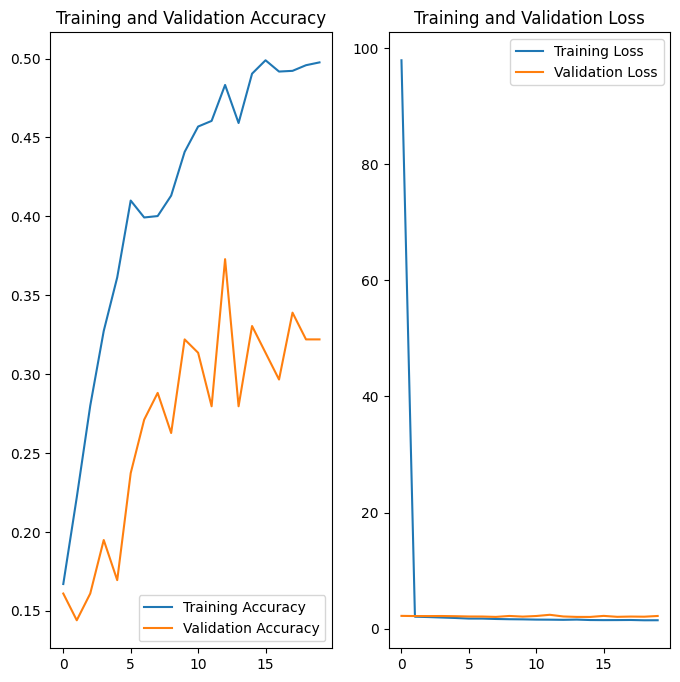

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####  Model 2 Infrences :         
Training Accuracy: Steady improvement and stabilizes near 0.5.

Validation Accuracy: Relatively close to training accuracy, stabilizing around 0.35-0.4.

Training Loss: Starts very high but rapidly drops and stabilizes.

Validation Loss: Consistent, slightly above training loss.

#### Class Imbalance Check.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 1000x1000 with 0 Axes>

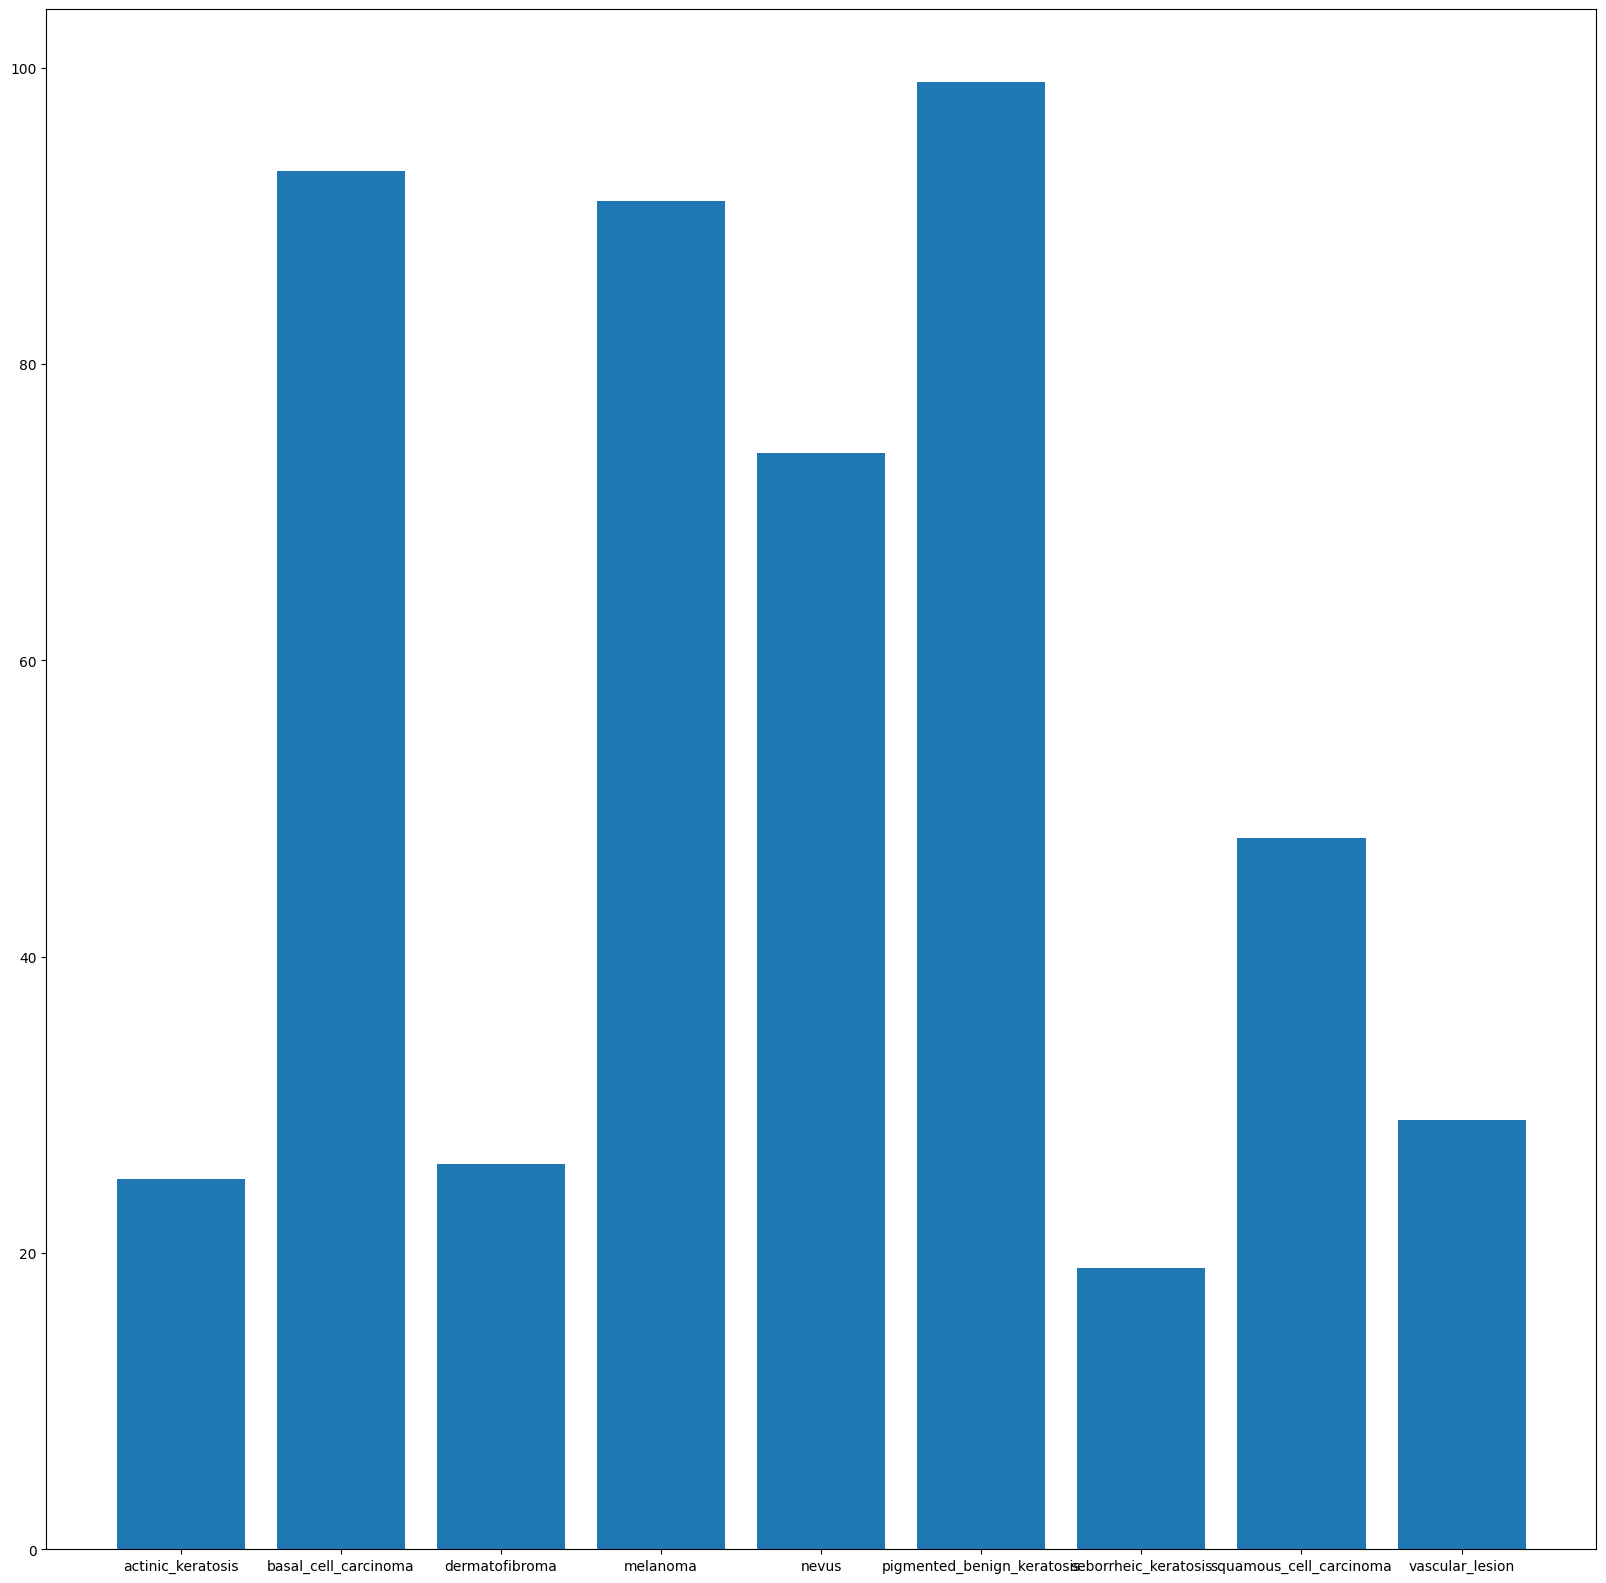

In [41]:
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i])

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

Highest Value: The tallest bar corresponds to "pigmented_benign_keratosis", reaching a value of 100.
Lowest Value: The shortest bar corresponds to "actinic_keratosis", with a value of 20


#### **Model Budiling 3**
Rectifying the class imbalance


In [43]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [52]:
import Augmentor
from pathlib import Path


path_to_training_dataset = Path(data_dir_train)


class_names = ['actinic_keratosis', 'basal_cell_carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented_benign_keratosis', 'seborrheic_keratosis', 'squamous_cell_carcinoma', 'vascular_lesion']

for i in class_names:
    # Convert to string and concatenate with class name

    class_path = str(path_to_training_dataset / i)
    print(f"Processing images in: {class_path}")
    p = Augmentor.Pipeline(class_path)

    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  # Adding 500 samples per class



Processing images in: /content/gdrive/MyDrive/CNN_assignment/Skincancer/Train/actinic_keratosis
Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skincancer/Train/actinic_keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C13A418C310>: 100%|██████████| 500/500 [00:19<00:00, 25.87 Samples/s]


Processing images in: /content/gdrive/MyDrive/CNN_assignment/Skincancer/Train/basal_cell_carcinoma
Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skincancer/Train/basal_cell_carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C13BB6E4E80>: 100%|██████████| 500/500 [00:22<00:00, 22.50 Samples/s]


Processing images in: /content/gdrive/MyDrive/CNN_assignment/Skincancer/Train/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skincancer/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C13ABF217B0>: 100%|██████████| 500/500 [00:19<00:00, 25.39 Samples/s]


Processing images in: /content/gdrive/MyDrive/CNN_assignment/Skincancer/Train/melanoma
Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skincancer/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C13A418C310>: 100%|██████████| 500/500 [01:16<00:00,  6.52 Samples/s]


Processing images in: /content/gdrive/MyDrive/CNN_assignment/Skincancer/Train/nevus
Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skincancer/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7C13BB6DFB80>: 100%|██████████| 500/500 [01:18<00:00,  6.35 Samples/s]


Processing images in: /content/gdrive/MyDrive/CNN_assignment/Skincancer/Train/pigmented_benign_keratosis
Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skincancer/Train/pigmented_benign_keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C133A6FA590>: 100%|██████████| 500/500 [00:22<00:00, 22.23 Samples/s]


Processing images in: /content/gdrive/MyDrive/CNN_assignment/Skincancer/Train/seborrheic_keratosis
Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skincancer/Train/seborrheic_keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C14428FDA80>: 100%|██████████| 500/500 [00:40<00:00, 12.30 Samples/s]


Processing images in: /content/gdrive/MyDrive/CNN_assignment/Skincancer/Train/squamous_cell_carcinoma
Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skincancer/Train/squamous_cell_carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C13BB6E4E80>: 100%|██████████| 500/500 [00:21<00:00, 22.86 Samples/s]


Processing images in: /content/gdrive/MyDrive/CNN_assignment/Skincancer/Train/vascular_lesion
Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skincancer/Train/vascular_lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C133A29DCC0>: 100%|██████████| 500/500 [00:21<00:00, 23.16 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [53]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [54]:
import os
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/CNN_assignment/Skincancer/Train/nevus/output/nevus_original_ISIC_0000268.jpg_c5643969-9eec-4214-86cd-62f58ef91814.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skincancer/Train/nevus/output/nevus_original_ISIC_0026709.jpg_b752bea0-fc3b-4ccf-b85f-19745f1f6358.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skincancer/Train/nevus/output/nevus_original_ISIC_0029309.jpg_d3a0197d-16bf-4825-8ddb-ea04e0c94899.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skincancer/Train/nevus/output/nevus_original_ISIC_0000396.jpg_b8ca9695-48cb-4474-b2e7-87cbda52d4b2.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skincancer/Train/nevus/output/nevus_original_ISIC_0027172.jpg_571bdacb-47ef-4b39-9161-25a12be4cef9.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skincancer/Train/nevus/output/nevus_original_ISIC_0026857.jpg_bc6ae35c-48cd-4a54-b754-5a6b964af26c.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skincancer/Train/nevus/output/nevus_original_ISIC_0000371.jpg_b1deeb9f-5570-4126-a0

In [58]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [81]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [82]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [83]:
new_df['Label'].value_counts()

,count
Label,
nevus,500
dermatofibroma,500
melanoma,500
basal_cell_carcinoma,500
pigmented_benign_keratosis,500
seborrheic_keratosis,500
squamous_cell_carcinoma,500
vascular_lesion,500
actinic_keratosis,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Training the model 3 on the data created using Augmentor

In [59]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset for model 3

In [61]:
data_dir_train="/content/gdrive/MyDrive/CNN_assignment/Skincancer/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)


class_names = train_ds.class_names
num_classes = len(class_names)

# Function to apply one-hot encoding to labels
def one_hot_encode(image, label):
    label = tf.one_hot(label, depth=num_classes)
    return image, label

# Apply the one-hot encoding function to the dataset
train_ds = train_ds.map(one_hot_encode)

# Verify the dataset structure
for image, label in train_ds.take(1):
    print("Image shape:", image.shape)
    print("Label shape (one-hot):", label.shape)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Image shape: (32, 180, 180, 3)
Label shape (one-hot): (32, 9)


In [62]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = val_ds.map(one_hot_encode)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [63]:
model = Sequential()

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))

# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 90, 90, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 90, 90, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 43, 43, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 43, 43, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 56448)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       7,225,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 7,367,465 (28.10 MB)

 Trainable params: 7,366,761 (28.10 MB)

 Non-trainable params: 704 (2.75 KB)

#### Compiling Model 3

In [64]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [65]:
epochs = 50

batch_size = 10
history = model.fit(train_ds,
  epochs = epochs, verbose = 1,  validation_data=val_ds)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 74s 330ms/step - accuracy: 0.2698 - loss: 2.1415 - val_accuracy: 0.1173 - val_loss: 11.4936
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 251ms/step - accuracy: 0.4156 - loss: 1.6377 - val_accuracy: 0.1767 - val_loss: 4.4613
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 83s 258ms/step - accuracy: 0.4759 - loss: 1.4621 - val_accuracy: 0.3333 - val_loss: 2.2144
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 248ms/step - accuracy: 0.5204 - loss: 1.3098 - val_accuracy: 0.2895 - val_loss: 2.2130
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 84s 258ms/step - accuracy: 0.5708 - loss: 1.1816 - val_accuracy: 0.4536 - val_loss: 1.5244
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 264ms/step - accuracy: 0.5934 - loss: 1.1044 - val_accuracy: 0.3304 - val_loss: 1.9583
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 82s 264ms/step - accuracy: 0.6221 - loss: 1.0427 - val_accuracy: 0.3801 - val_loss: 2.0234
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 79s 248ms/step - accuracy: 0.6416 - loss: 

####   Visualize the model results 3

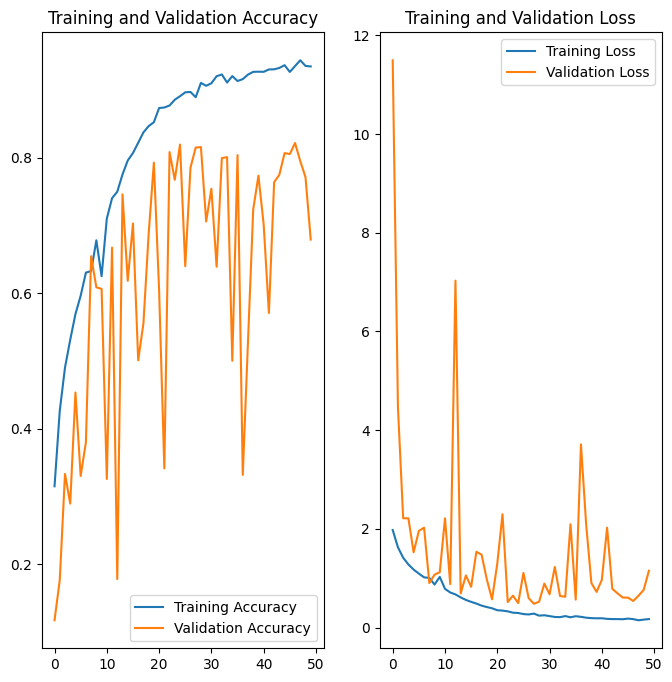

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Model Infrence 3
Training Accuracy: Gradually increases and stabilizes near 0.9.

Validation Accuracy: Highly volatile with large fluctuations.

Training Loss: Decreases steadily and stabilizes at a low value.

Validation Loss: Erratic with spikes.


#### Validating on Test Data

In [91]:
import os
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

# Directories for train, validation, and test datasets
data_dir_train = "/content/gdrive/MyDrive/CNN_assignment/Skincancer/Train"
data_dir_test = "/content/gdrive/MyDrive/CNN_assignment/Skincancer/Test"

# Parameters
img_height = 180
img_width = 180
batch_size = 10

# Load and preprocess the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Load and preprocess the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Get class names and number of classes
class_names = train_ds.class_names
num_classes = len(class_names)

# Function to apply one-hot encoding to labels
def one_hot_encode(image, label):
    label = tf.one_hot(label, depth=num_classes)
    return image, label

# Apply one-hot encoding to the datasets
train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)

# Combine the training and validation datasets
combined_ds = train_ds.concatenate(val_ds)

# Model architecture
model = Sequential()

# Add layers to the model
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Model summary
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the combined dataset (train + validation)
epochs = 10
history = model.fit(combined_ds, epochs=epochs, verbose=1)

# Prepare and load the test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_ds = test_ds.map(one_hot_encode)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Optionally, get predictions on the test dataset and calculate accuracy manually
all_test_images = []
all_actual_classes = []
all_predicted_classes = []

for image, label in test_ds:
    # Store the actual class labels
    all_actual_classes.extend(np.argmax(label, axis=1))

    # Make predictions
    pred = model.predict(image, verbose=0)
    pred_class = np.argmax(pred, axis=1)
    all_predicted_classes.extend(pred_class)

# Calculate accuracy manually using sklearn
test_accuracy_manual = accuracy_score(all_actual_classes, all_predicted_classes)
print(f"Test Accuracy (manual calculation): {test_accuracy_manual * 100:.2f}%")


Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 90, 90, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 90, 90, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 43, 43, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 43, 43, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 56448)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │       7,225,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 7,367,465 (28.10 MB)

 Trainable params: 7,366,761 (28.10 MB)

 Non-trainable params: 704 (2.75 KB)

Epoch 1/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 77s 94ms/step - accuracy: 0.2624 - loss: 2.3136
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 47s 69ms/step - accuracy: 0.3651 - loss: 1.7653
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 46s 68ms/step - accuracy: 0.4325 - loss: 1.5375
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 82s 68ms/step - accuracy: 0.4838 - loss: 1.4077
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 85s 72ms/step - accuracy: 0.5109 - loss: 1.3493
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 83s 74ms/step - accuracy: 0.5190 - loss: 1.3205
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 79s 69ms/step - accuracy: 0.5518 - loss: 1.2432
Epoch 8/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 45s 67ms/step - accuracy: 0.5418 - loss: 1.2153
Epoch 9/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 82s 67ms/step - accuracy: 0.5726 - loss: 1.1974
Epoch 10/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 89s 78ms/step - accuracy: 0.5948 - loss: 1.1123
Found 118 files belonging to 9 classes.
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 257ms/step - accuracy: 0.4010 - loss: 1.9251
Test


***Conclusion***

     

1.   **Class Rebalancing**


*   Helped reduce overfitting, as evidenced by a decrease in loss.
*   However, it led to a significant drop in accuracy.


2.   **Initial Training Without Augmentation**


*   Training the model without using an ImageDataGenerator resulted in severe overfitting.
*   The model performed well on the training data but failed to generalize effectively on validation data


3.   **Introduction of Dropout and ImageDataGenerator**


*   Dropout layers were added to reduce overfitting by preventing reliance on specific neurons.
*   The ImageDataGenerator augmented the training data, improving diversity and reducing overfitting.


4.   **Incorporating Batch Normalization and Augmentation**


*   Batch normalization stabilized the training process and improved convergence.
*   Data augmentation further enhanced the model’s robustness by creating more varied training samples.


5.   **Overall Impact**


*   These steps collectively improved the model’s ability to generalize and reduced overfitting









